In [1]:
%load_ext lab_black
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from typing import List, Tuple
import seaborn as sns
import sys
import wandb
from scipy import stats as sst
from matplotlib import font_manager as fm, pyplot as plt
import matplotlib as mpl

### Preamble
Paths, plot formatting, colors, and WandB stuff

In [2]:
RESULTS_DIR = "./analyze_entropy_vs_mdl_synthetic/"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

In [3]:
# Plot formatting
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

try:
    # Set the font properties globally
    font_path = "./fonts/cmunbx.otf"
    font_prop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=font_prop.get_name())
except:
    print("Unable to set font to Computer Modern (cmunbx.otf)")

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "analyze_entropy_vs_mdl_synthetic.ipynb"
)
# entity, PROJECT_NAME = "kdu", "bauer-bert-synthetic"  # set to your entity and project
entity, PROJECT_NAME = (
    "ethz-rycolab",
    "bauer-bert-synthetic",
)  # set to your entity and project
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_bincount_mdl_{datetime.datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis", "compute_mdl"],
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: No data
wandb: ERROR Failed to sample metric: Not Supported


{}


In [5]:
valid_run_tags: set = {"compute_mdl", "official_result1", "mdl_fixed", "36classes"}
api = wandb.Api()
runs = api.runs(entity + "/" + PROJECT_NAME)
summary_list, config_list, name_list, run_id_list = [], [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    if valid_run_tags.issubset(set(run.tags)):
        if "analysis" not in run.tags:
            summary_list.append(run.summary._json_dict)

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k, v in run.config.items() if not k.startswith("_")}
            )

            # .name is the human-readable name of the run.
            name_list.append(run.name)
            run_id_list.append(run.id)

runs_df = pd.DataFrame(
    {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "id": run_id_list,
    }
)

In [6]:
runs_df

,summary,config,name,id
0,"{'_step': 2, 'test_loss': 0.4192031919956207, ...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",rare-pond-826,2q2e3r6f
1,"{'_runtime': 5.555126667022705, 'test_acc': 0....","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",fresh-energy-825,2focfb0s
2,"{'epoch': 0, 'test_loss': 0.5014776587486267, ...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",royal-salad-824,w8644peg
3,"{'_wandb': {'runtime': 4}, '_runtime': 5.33141...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",skilled-sound-823,1gockgdq
4,"{'epoch': 0, '_wandb': {'runtime': 5}, 'test_f...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",electric-wind-822,2cbhd3na
...,...,...,...,...
250,"{'tss-8_test_f1': 0.5, 'tss-1800_test_f1': 0.5...","{'SEED': 1, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",clear-river-476,1me0jbpi
251,"{'epoch': 0, 'test_f1': 0.4749999940395355, 't...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",sunny-cherry-475,2kuqwqo7
252,"{'_timestamp': 1684337450.668493, 'tss-12_val_...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",zany-sunset-474,29l99ivj
253,"{'tss-648_val_f1': 0.5, 'tss-648_val_acc': 0.5...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",upbeat-brook-473,3r3cqul0


In [7]:
runs_df = runs_df[(runs_df["summary"] != dict()) & (runs_df["config"] != dict())]
runs_df

,summary,config,name,id
0,"{'_step': 2, 'test_loss': 0.4192031919956207, ...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",rare-pond-826,2q2e3r6f
1,"{'_runtime': 5.555126667022705, 'test_acc': 0....","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",fresh-energy-825,2focfb0s
2,"{'epoch': 0, 'test_loss': 0.5014776587486267, ...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",royal-salad-824,w8644peg
3,"{'_wandb': {'runtime': 4}, '_runtime': 5.33141...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",skilled-sound-823,1gockgdq
4,"{'epoch': 0, '_wandb': {'runtime': 5}, 'test_f...","{'SEED': 2, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",electric-wind-822,2cbhd3na
...,...,...,...,...
250,"{'tss-8_test_f1': 0.5, 'tss-1800_test_f1': 0.5...","{'SEED': 1, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",clear-river-476,1me0jbpi
251,"{'epoch': 0, 'test_f1': 0.4749999940395355, 't...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",sunny-cherry-475,2kuqwqo7
252,"{'_timestamp': 1684337450.668493, 'tss-12_val_...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",zany-sunset-474,29l99ivj
253,"{'tss-648_val_f1': 0.5, 'tss-648_val_acc': 0.5...","{'SEED': 0, 'SEQLEN': 36, 'VALSIZE': 360, 'TES...",upbeat-brook-473,3r3cqul0


In [8]:
def convert_dict_to_df(df, col_name):
    return df[col_name].apply(lambda row: pd.Series(row))

In [9]:
expanded_df = pd.concat(
    [
        convert_dict_to_df(runs_df, "summary"),
        convert_dict_to_df(runs_df, "config"),
        convert_dict_to_df(
            convert_dict_to_df(runs_df, "config"), "DATASET_KWARGS_IDENTIFIABLE"
        ),
        convert_dict_to_df(convert_dict_to_df(runs_df, "summary"), "val"),
        runs_df[["name", "id"]],
    ],
    axis=1,
)
expanded_df.info()
list(expanded_df.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 254
Columns: 164 entries, _step to id
dtypes: bool(2), float64(125), int64(21), object(16)
memory usage: 323.9+ KB


['_step',
 'test_loss',
 '_timestamp',
 'test_acc',
 'val_data',
 'val_labels',
 'val_X_is_ood',
 'epoch',
 '_wandb',
 'test_f1',
 '_runtime',
 'trainer/global_step',
 'val',
 'tss-8_test_f1',
 'tss-72_val_acc',
 'tss-360_val_acc',
 'tss-36_val_loss',
 'tss-648_val_acc',
 'tss-1800_val_loss',
 'tss-648_test_loss',
 'tss-144_train_loss',
 'data_cost',
 'tss-4_val_loss',
 'tss-216_test_f1',
 'tss-3600_test_f1',
 'tss-144_val_acc',
 'tss-4_train_loss',
 'tss-20_test_f1',
 'tss-36_val_acc',
 'tss-4_test_f1',
 'tss-144_test_loss',
 'tss-2_val_acc',
 'tss-72_test_acc',
 'tss-648_val_loss',
 'tss-1224_val_loss',
 'tss-216_test_loss',
 'tss-12_test_acc',
 'model_cost',
 'tss-12_val_acc',
 'tss-20_val_loss',
 'tss-36_test_acc',
 'tss-8_test_loss',
 'tss-72_test_loss',
 'tss-1224_test_loss',
 'tss-2_test_loss',
 'tss-216_train_loss',
 'tss-1800_train_loss',
 'tss-12_val_f1',
 'tss-1800_val_f1',
 'tss-216_val_acc',
 'tss-2_val_f1',
 'tss-36_test_f1',
 'tss-648_val_f1',
 'tss-20_train_loss',
 'tss

In [10]:
# Filter and modify expanded_df
expanded_df["num_classes"].fillna(2, inplace=True)
VALID_NUM_EPOCHS = [50]
VALID_VOCAB_SIZE = [60]
expanded_df = expanded_df[expanded_df["NUM_EPOCHS"].isin(VALID_NUM_EPOCHS)]
expanded_df = expanded_df[expanded_df["VOCABSIZE"].isin(VALID_VOCAB_SIZE)]

In [11]:
expanded_df[expanded_df["DATASET_NAME"] == "AdjacentDuplicate"][
    [
        "name",
        "SEED",
        "total_mdl",
        "data_cost",
        "DATASET_NAME",
        "seq_len",
        "num_classes",
        "NUM_EPOCHS",
    ]
]

,name,SEED,total_mdl,data_cost,DATASET_NAME,seq_len,num_classes,NUM_EPOCHS
67,dazzling-bush-747,1,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
69,treasured-rain-746,2,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
74,cool-donkey-741,0,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
173,wobbly-valley-597,1,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
174,expert-water-595,0,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
180,expert-breeze-596,2,NaN,NaN,AdjacentDuplicate,36.0,2.0,50
225,vague-plasma-544,2,16.792520,0.680403,AdjacentDuplicate,36.0,2.0,50
238,drawn-durian-531,0,16.522892,0.632992,AdjacentDuplicate,36.0,2.0,50
241,helpful-pyramid-529,1,17.582342,0.641339,AdjacentDuplicate,36.0,2.0,50


In [12]:
mdl_df = expanded_df[
    [
        "SEED",
        "total_mdl",
        "data_cost",
        "DATASET_NAME",
        "seq_len",
        "num_classes",
        "TOKENSETMAX",
    ]
]
mdl_df = mdl_df[mdl_df["total_mdl"].notna()]
mdl_df["dataset"] = mdl_df["DATASET_NAME"] + "_" + mdl_df["num_classes"].astype(str)
mdl_df.loc[mdl_df["DATASET_NAME"] == "ContainsTokenSet", "dataset"] = (
    mdl_df[mdl_df["DATASET_NAME"] == "ContainsTokenSet"]["dataset"]
    + "_"
    + mdl_df["TOKENSETMAX"].astype(str)
)
mdl_df.loc[mdl_df["DATASET_NAME"] == "ContainsTokenSetOOD", "dataset"] = (
    mdl_df[mdl_df["DATASET_NAME"] == "ContainsTokenSetOOD"]["dataset"]
    + "_"
    + mdl_df["TOKENSETMAX"].astype(str)
)
print(len(mdl_df))
mdl_df

81


,SEED,total_mdl,data_cost,DATASET_NAME,seq_len,num_classes,TOKENSETMAX,dataset
42,2,15.368471,0.009029,ContainsTokenSetOOD,36.0,2.0,30,ContainsTokenSetOOD_2.0_30
43,0,15.420922,0.000329,ContainsTokenSetOOD,36.0,2.0,5,ContainsTokenSetOOD_2.0_5
44,0,16.020266,0.004427,ContainsTokenSetOOD,36.0,2.0,10,ContainsTokenSetOOD_2.0_10
45,0,16.019866,0.044950,ContainsTokenSetOOD,36.0,2.0,25,ContainsTokenSetOOD_2.0_25
46,1,15.477911,0.000124,ContainsTokenSetOOD,36.0,2.0,5,ContainsTokenSetOOD_2.0_5
...,...,...,...,...,...,...,...,...
239,0,16.570157,0.074520,FirstTokenRepeatedLast,36.0,2.0,-1,FirstTokenRepeatedLast_2.0
240,2,16.411730,0.012125,FirstTokenRepeatedImmediately,36.0,2.0,-1,FirstTokenRepeatedImmediately_2.0
241,1,17.582342,0.641339,AdjacentDuplicate,36.0,2.0,-1,AdjacentDuplicate_2.0
242,1,16.689864,0.016168,FirstTokenRepeatedImmediately,36.0,2.0,-1,FirstTokenRepeatedImmediately_2.0


In [13]:
entropy_df = expanded_df[
    [
        "SEED",
        "num_classes",
        "DATASET_NAME",
        "TOKENSETMAX",
        "entropy",
        "accuracy",
        "grad",
        "abs_grad",
        "loss",
        "grads_per_example_per_token",
        "abs_val_grads_per_example_per_token",
        "is_correct_per_example",
        "entropies_per_example_per_token",
    ]
]
entropy_df = entropy_df[entropy_df["entropy"].notna()]
entropy_df = entropy_df[entropy_df["entropies_per_example_per_token"].notna()]
entropy_df["TOKENSETMAX"].fillna(-1.0, inplace=True)
entropy_df

,SEED,num_classes,DATASET_NAME,TOKENSETMAX,entropy,accuracy,grad,abs_grad,loss,grads_per_example_per_token,abs_val_grads_per_example_per_token,is_correct_per_example,entropies_per_example_per_token
21,2,2.0,ContainsTokenSetOOD,5,2264.661556,0.944444,-8.119320e-14,1.192398e+07,0.222897,"[[1.4533240404775776e-14, -6.923190680688742e-...","[[2945298.227814193, 113274.31331251746, 8099....","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[61.38225506491448, 61.24573767385651, 61.048..."
22,0,2.0,ContainsTokenSetOOD,25,2157.470277,0.888889,-4.960699e-11,1.606578e+07,0.359957,"[[2.0909584133588233e-10, -1.936454479406491e-...","[[485500.22378035367, 967204.4541865203, 11433...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[59.66506636849384, 58.620791051311144, 56.50..."
23,1,2.0,ContainsTokenSetOOD,20,2251.514478,0.897222,-1.165986e-09,5.577227e+07,0.594813,"[[-2.3047241459045464e-10, -6.904616223386839e...","[[10974140.659550909, 766155.572482454, 226513...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[[60.5847057996844, 60.695443381477354, 57.992..."
24,1,2.0,ContainsTokenSetOOD,35,2177.796283,0.947222,-6.835604e-10,4.005567e+07,0.248969,"[[6.261204052514062e-13, 5.170703004219596e-13...","[[6779975.884600297, 1541840.520080906, 416990...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[55.9741783029301, 58.15858623025075, 56.1268..."
25,1,2.0,ContainsTokenSetOOD,10,2189.667472,0.966667,3.949885e-10,1.397439e+08,0.199995,"[[-3.171935628955606e-16, 3.566809294696464e-1...","[[6641970.153508539, 71980.96677445497, 119730...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[61.49068101842143, 60.51882972150282, 61.132..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1,2.0,ContainsTokenSet,10,2257.717602,0.986111,7.609378e-10,7.947620e+06,0.084704,"[[-4.2785550577857873e-16, 6.742309650230061e-...","[[619471.4953948507, 23673.588887400227, 91817...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[64.11995586560033, 61.43514581874722, 63.242..."
120,2,2.0,ContainsTokenSet,10,2312.301324,0.983333,3.740422e-10,2.947152e+06,0.096850,"[[-1.1326041667036879e-11, 2.359282061581908e-...","[[99878.15602968152, 4799.330187337111, 22236....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[65.7921580398013, 63.37326052051599, 63.8257..."
121,0,2.0,ContainsTokenSet,25,2351.552951,0.994444,7.012757e-11,4.701612e+05,0.015902,"[[-3.120401466156552e-17, 2.2679335286874718e-...","[[25568.648170191023, 12377.158689596981, 8745...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[67.73095453998552, 66.4024056713477, 66.4490..."
122,1,2.0,ContainsTokenSet,1,2154.035049,1.000000,-4.741636e-17,2.506012e+05,0.000116,"[[-3.5708090851894334e-17, 3.1838585609326023e...","[[18105.587990351327, 2432.2881783620496, 1181...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[60.166264709296314, 60.421852442316265, 61.5..."


In [14]:
is_ood_df = expanded_df[
    [
        "SEED",
        "num_classes",
        "DATASET_NAME",
        "TOKENSETMAX",
        "val_X_is_ood",
        "val_data",
        "val_labels",
    ]
]
is_ood_df = is_ood_df[is_ood_df["val_X_is_ood"].notna()]
is_ood_df

,SEED,num_classes,DATASET_NAME,TOKENSETMAX,val_X_is_ood,val_data,val_labels
0,2,2.0,ContainsTokenSetOOD,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[25, 1, 53, 55, 14, 31, 32, 13, 34, 55, 28, 1...","[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, ..."
1,2,2.0,ContainsTokenSetOOD,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[8, 30, 23, 18, 21, 11, 14, 16, 12, 18, 25, 3...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ..."
2,2,2.0,ContainsTokenSetOOD,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[11, 8, 10, 20, 32, 1, 18, 6, 25, 16, 21, 59,...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."
3,2,2.0,ContainsTokenSetOOD,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[[3, 8, 19, 34, 55, 20, 53, 15, 23, 24, 6, 59,...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
4,2,2.0,ContainsTokenSetOOD,15,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[13, 34, 1, 52, 49, 8, 15, 13, 5, 57, 25, 8, ...","[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, ..."
5,2,2.0,ContainsTokenSetOOD,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[25, 53, 43, 9, 28, 35, 10, 7, 39, 36, 24, 56...","[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
6,2,2.0,ContainsTokenSetOOD,5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[4, 52, 58, 42, 4, 38, 51, 7, 7, 5, 27, 40, 5...","[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, ..."
7,1,2.0,ContainsTokenSetOOD,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[25, 1, 53, 55, 14, 31, 32, 13, 34, 55, 28, 1...","[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, ..."
8,1,2.0,ContainsTokenSetOOD,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[8, 30, 23, 18, 21, 11, 14, 16, 12, 18, 25, 3...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ..."
9,1,2.0,ContainsTokenSetOOD,25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[11, 8, 10, 20, 32, 1, 18, 6, 25, 16, 21, 59,...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."


In [15]:
# Combine mdl_df, entropy_df, and is_ood_df
mdl_and_entropy_df = entropy_df.merge(
    mdl_df, on=["SEED", "num_classes", "DATASET_NAME", "TOKENSETMAX"]
)
mdl_and_entropy_df = mdl_and_entropy_df.merge(
    is_ood_df, on=["SEED", "num_classes", "DATASET_NAME", "TOKENSETMAX"], how="left"
)

In [16]:
mdl_and_entropy_df["high_acc"] = mdl_and_entropy_df["accuracy"] > 0.9
mdl_and_entropy_df["is_binary"] = mdl_and_entropy_df["num_classes"] == 2
mdl_and_entropy_df["is_bincountones"] = (
    mdl_and_entropy_df["DATASET_NAME"] == "BinCountOnes"
)
mdl_and_entropy_df["log_num_classes"] = np.log(mdl_and_entropy_df["num_classes"])

### MDL for different datasets

Text(0.5, 1.0, 'MDL of all synthetic datasets')

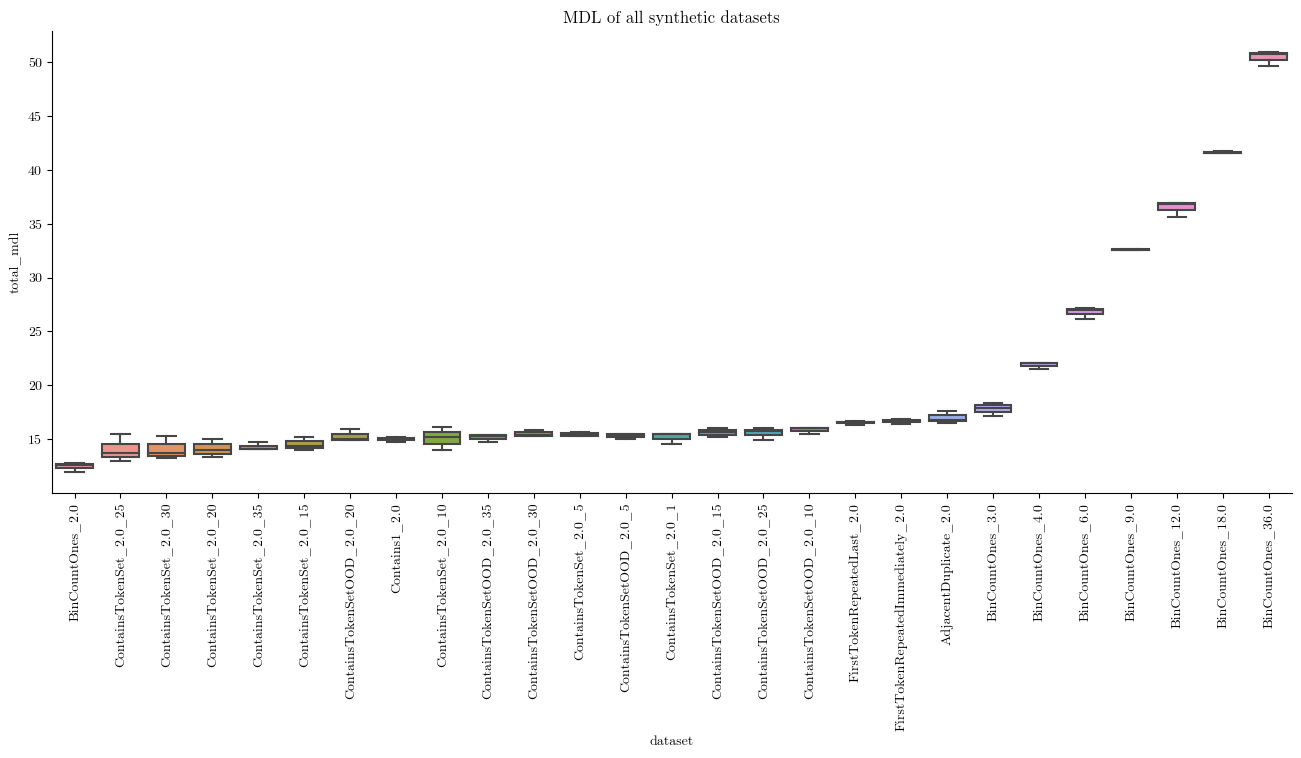

In [17]:
# MDL for all datasets
fig, ax = plt.subplots(figsize=(16, 6))
mdl_ranks = mdl_df.groupby("dataset")["total_mdl"].agg("median").sort_values().index
sns.boxplot(data=mdl_df, x="dataset", y="total_mdl", ax=ax, order=mdl_ranks)
plt.xticks(rotation=90)
ax.set_title("MDL of all synthetic datasets")

Text(0.5, 1.0, 'MDL of all synthetic datasets')

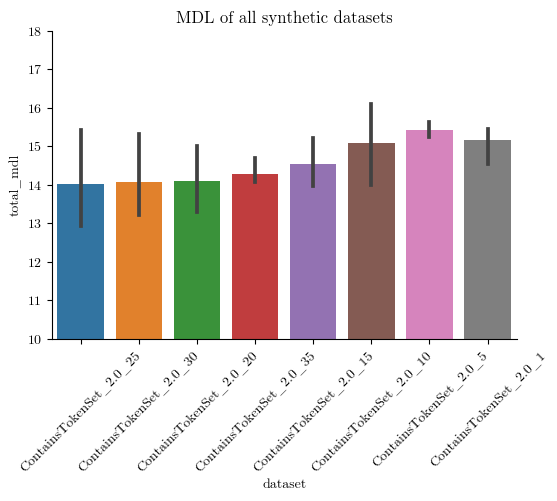

In [18]:
# MDL for ContainsTokenSet datasets only
fig, ax = plt.subplots(figsize=(6, 4))
cts_df = mdl_df[mdl_df["DATASET_NAME"] == "ContainsTokenSet"]
mdl_ranks = cts_df.groupby("dataset")["total_mdl"].agg("median").sort_values().index
sns.barplot(data=cts_df, x="dataset", y="total_mdl", ax=ax, order=mdl_ranks)
plt.xticks(rotation=45)
ax.set(ylim=(10, 18))
ax.set_title("MDL of all synthetic datasets")

Text(0.5, 1.0, 'MDL of all synthetic datasets')

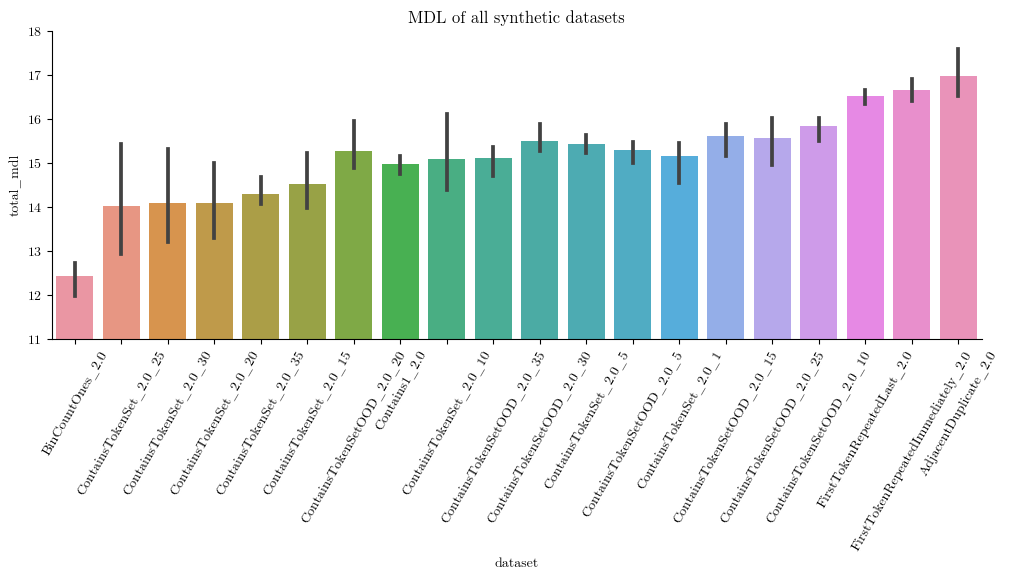

In [19]:
# MDL for binary datasets only
fig, ax = plt.subplots(figsize=(12, 4))
binary_df = mdl_df[mdl_df["num_classes"] == 2]
mdl_ranks = binary_df.groupby("dataset")["total_mdl"].agg("median").sort_values().index
sns.barplot(data=binary_df, x="dataset", y="total_mdl", ax=ax, order=mdl_ranks)
plt.xticks(rotation=60)
ax.set(ylim=(11, 18))
ax.set_title("MDL of all synthetic datasets")

In [20]:
# Filter out poorly performing runs
mdl_and_entropy_df_high_acc = mdl_and_entropy_df[mdl_and_entropy_df["high_acc"]]
mdl_and_entropy_df_high_acc.info()

mdl_and_entropy_df_high_acc_binary = mdl_and_entropy_df_high_acc[
    mdl_and_entropy_df_high_acc["num_classes"] == 2.0
]
mdl_and_entropy_df_high_acc_bincountones = mdl_and_entropy_df_high_acc[
    mdl_and_entropy_df_high_acc["DATASET_NAME"] == "BinCountOnes"
]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 0 to 80
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SEED                                 68 non-null     int64  
 1   num_classes                          68 non-null     float64
 2   DATASET_NAME                         68 non-null     object 
 3   TOKENSETMAX                          68 non-null     int64  
 4   entropy                              68 non-null     float64
 5   accuracy                             68 non-null     float64
 6   grad                                 68 non-null     float64
 7   abs_grad                             68 non-null     float64
 8   loss                                 68 non-null     float64
 9   grads_per_example_per_token          68 non-null     object 
 10  abs_val_grads_per_example_per_token  68 non-null     object 
 11  is_correct_per_example            

'#440154'

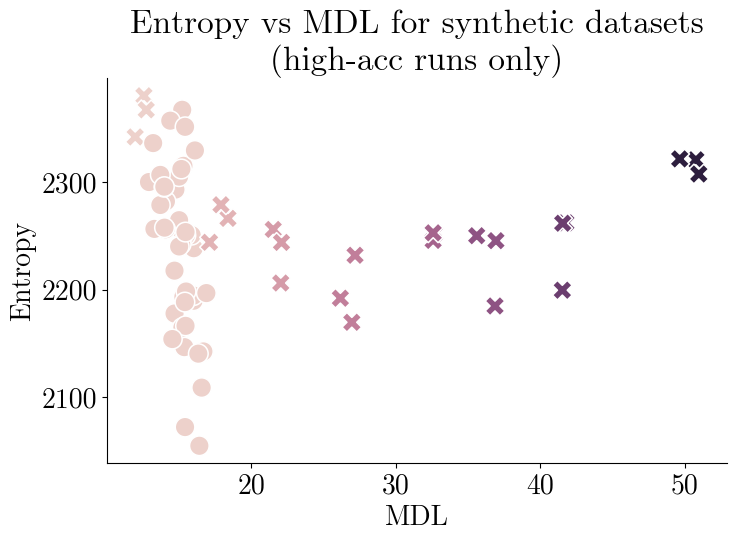

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


In [26]:
plt.rc("font", size=20)
fig, ax = plt.subplots(figsize=(8, 5))
sc = sns.scatterplot(
    data=mdl_and_entropy_df_high_acc,
    x="total_mdl",
    y="entropy",
    hue="log_num_classes",
    style="is_bincountones",
    ax=ax,
    legend=False,
    s=200,
)
# ax.legend(
#     # title="Task type",
#     # handles=ax.get_legend_handles_labels()[0],
#     # labels=["Binary", "BinCountOnes"],
#     bbox_to_anchor=(1.0, 1.0),
# )
ax.set_title("Entropy vs MDL for synthetic datasets\n(high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")
# fig.tight_layout()
plot_name = "entropy_vs_mdl_high_acc_only_hue-class_style-bincountones"
save_path = os.path.join(PLOTS_DIR, f"{plot_name}.png")
save_path_pdf = os.path.join(PLOTS_DIR, f"{plot_name}.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(save_path)})
mpl.colors.to_hex(plt.gca().get_children()[0].to_rgba(0))

(10.0, 55.0)

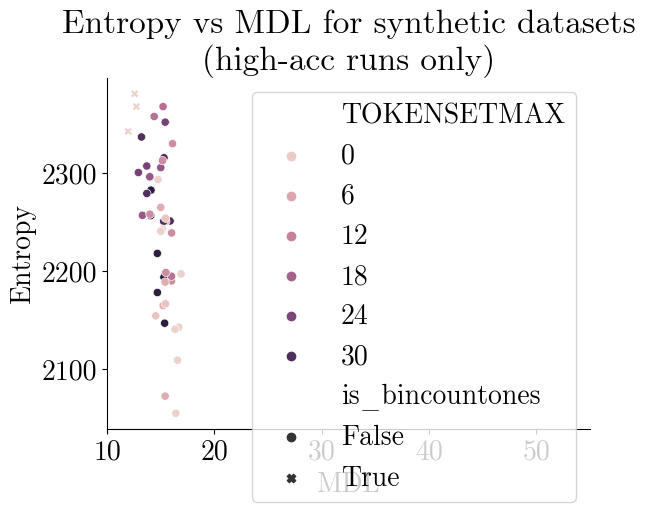

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df_high_acc_binary,
    x="total_mdl",
    y="entropy",
    hue="TOKENSETMAX",
    style="is_bincountones",
    ax=ax,
)
fig.tight_layout()
ax.legend(
    # title="Task type",
    # handles=ax.get_legend_handles_labels()[0],
    # labels=["Binary", "BinCountOnes"],
    bbox_to_anchor=(1.0, 1.0),
)
ax.set_title("Entropy vs MDL for synthetic datasets\n(high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")
ax.set_xlim((10, 55))

Text(9.222222222222216, 0.5, 'Entropy')

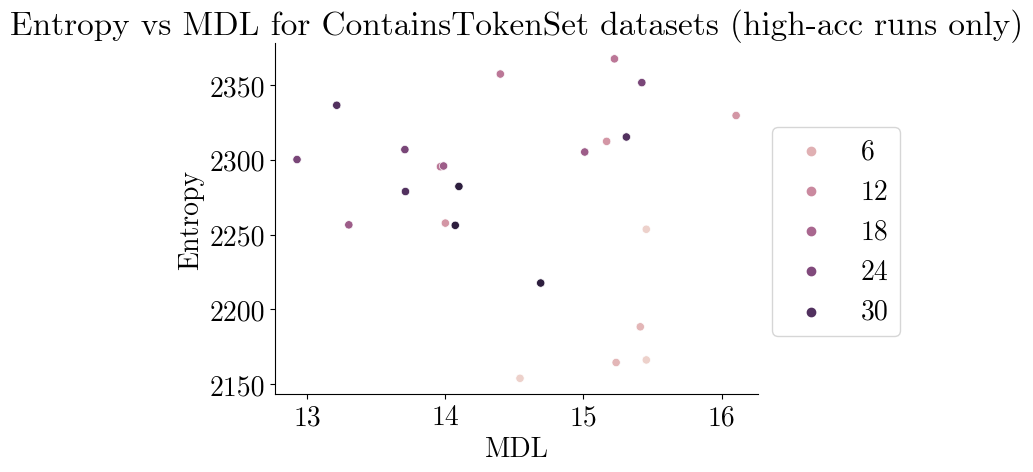

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df_high_acc[
        mdl_and_entropy_df_high_acc["DATASET_NAME"] == "ContainsTokenSet"
    ],
    x="total_mdl",
    y="entropy",
    hue="TOKENSETMAX",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 0.8))
ax.set_title("Entropy vs MDL for ContainsTokenSet datasets (high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")

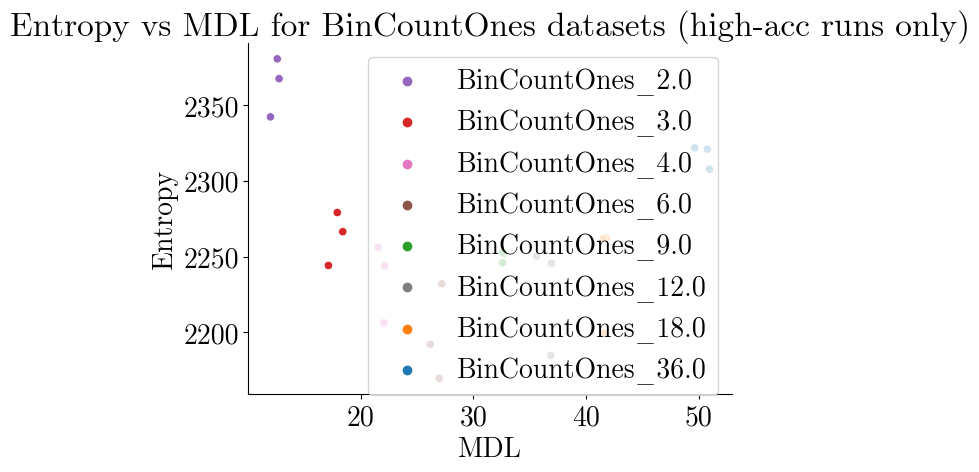

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df_high_acc[
        mdl_and_entropy_df_high_acc["DATASET_NAME"] == "BinCountOnes"
    ],
    x="total_mdl",
    y="entropy",
    hue="dataset",
    ax=ax,
)
fig.tight_layout()
ax.set_title("Entropy vs MDL for BinCountOnes datasets (high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")

# Create a new legend with the desired order using a lambda function
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = zip(
    *sorted(zip(handles, labels), key=lambda x: float(x[1].split("_")[1]))
)
ax.legend(new_handles, new_labels)
# ax.legend(bbox_to_anchor=(1.0, 1.0))

save_path = os.path.join(PLOTS_DIR, "entropy_vs_mdl_bincountones_high_acc_only.png")
save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_mdl_bincountones_high_acc_only.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"entropy_vs_mdl_bincountones_high_acc_only": wandb.Image(save_path)})
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")

('BinCountOnes_2.0', 'Contains1_2.0', 'ContainsTokenSet_2.0_1', 'ContainsTokenSet_2.0_5', 'ContainsTokenSet_2.0_10', 'ContainsTokenSet_2.0_15', 'ContainsTokenSet_2.0_20', 'ContainsTokenSet_2.0_25', 'ContainsTokenSet_2.0_30', 'ContainsTokenSet_2.0_35', 'ContainsTokenSetOOD_2.0_5', 'ContainsTokenSetOOD_2.0_10', 'ContainsTokenSetOOD_2.0_15', 'ContainsTokenSetOOD_2.0_30', 'ContainsTokenSetOOD_2.0_35', 'FirstTokenRepeatedImmediately_2.0', 'FirstTokenRepeatedLast_2.0')


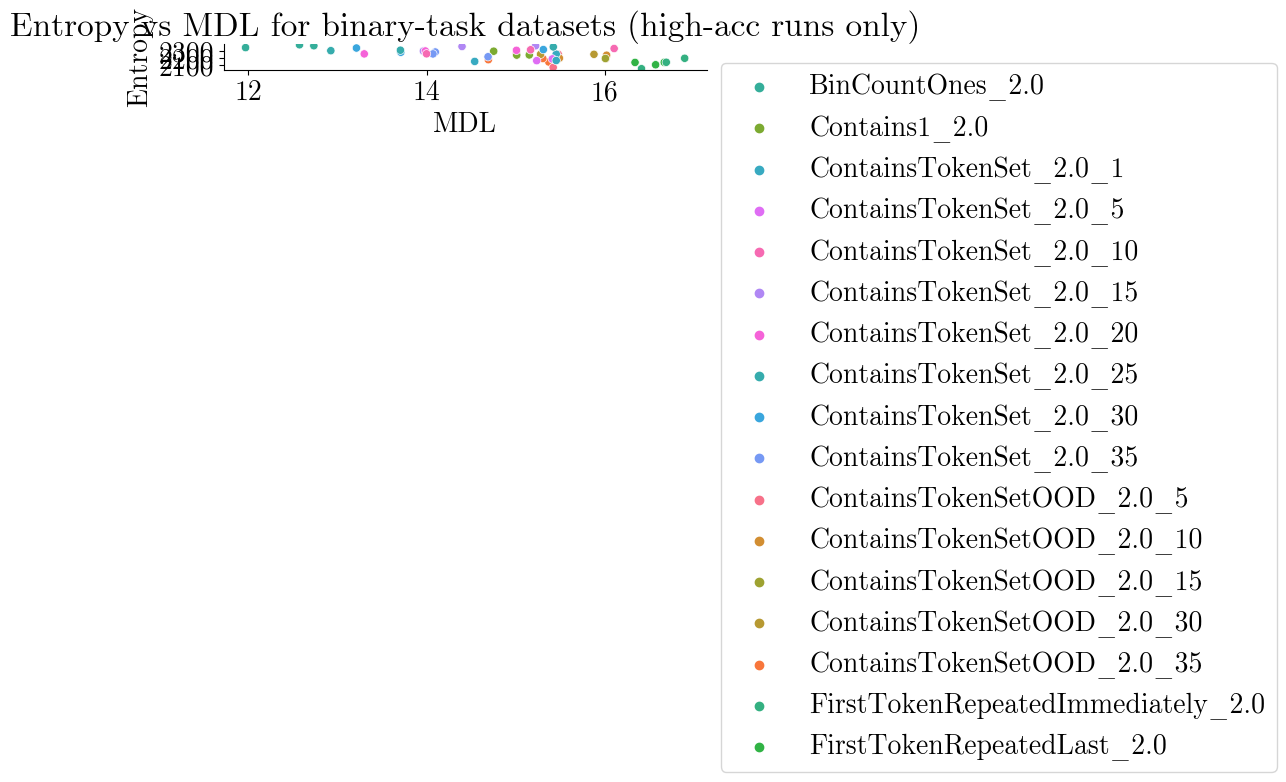

In [25]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df_high_acc[mdl_and_entropy_df_high_acc["num_classes"] == 2.0],
    x="total_mdl",
    y="entropy",
    hue="dataset",
    ax=ax,
)
fig.tight_layout()
ax.set_title("Entropy vs MDL for binary-task datasets (high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")

# Create a new legend with the desired order using a lambda function
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = zip(
    *sorted(
        zip(handles, labels),
        key=lambda x: (
            x[1].split("_")[0],  # This sorts the datasets by their name
            float(x[1].split("_")[-1]),  # This sorts by the ContainsTokenSet size
        ),
    )
)
print(new_labels)
ax.legend(new_handles, new_labels, bbox_to_anchor=(1.0, 0.8))
# ax.legend()

save_path = os.path.join(PLOTS_DIR, "entropy_vs_mdl_binary_high_acc_only.png")
save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_mdl_binary_high_acc_only.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"entropy_vs_mdl_binary_high_acc_only": wandb.Image(save_path)})

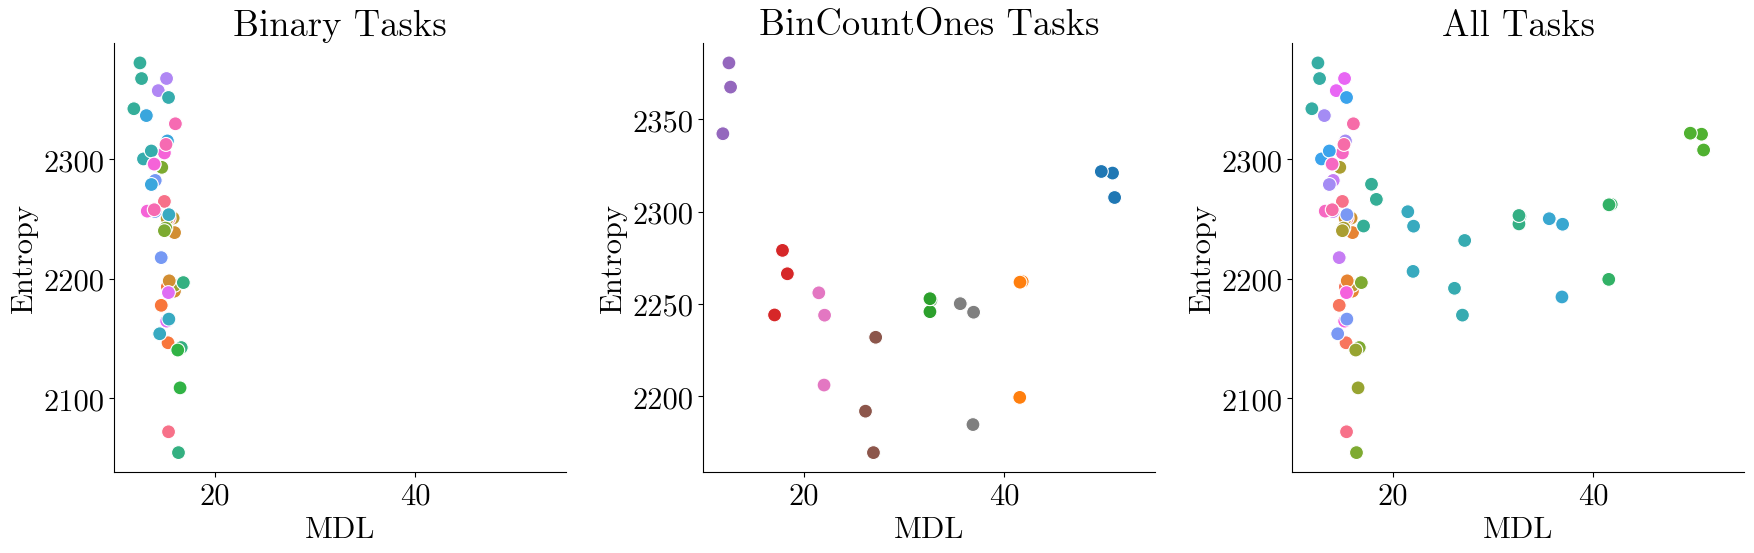

In [26]:
font = {
    # "family": "normal",
    # "weight": "bold",
    "size": 22,
}
plt.rc("font", **font)
dfs = [
    mdl_and_entropy_df_high_acc_binary,
    mdl_and_entropy_df_high_acc_bincountones,
    mdl_and_entropy_df_high_acc,
]
titles = ["Binary Tasks", "BinCountOnes Tasks", "All Tasks"]
ncols = 3
nrows = int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
# plt.tight_layout()
for i in range(len(dfs)):
    use_legend = False  # (i == len(dfs) - 1)
    row, col = i // ncols, i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    sns.scatterplot(
        data=dfs[i],
        x="total_mdl",
        y="entropy",
        hue="dataset",
        # style="is_correct",
        ax=ax,
        legend=use_legend,
        s=100,
    )
    # ax.set_ylim((12, 50))
    ax.set_title(titles[i], wrap=True)
    ax.set_xlabel("MDL")
    ax.set_ylabel("Entropy")
    ax.set_xlim((10, 55))
    # ax.set_xticks(ticks=sorted(dfs[i]["layer_num"].unique()))
# linecolors = [l.get_color() for l in ax.get_lines()]
# print(linecolors)
# # Lolmao you can't make a title have different colors in it so...manual labor it is l o l.
# offset = 0.23
# fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
# fig.text(0.145 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
# fig.text(0.22 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
# fig.text(0.305 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
# fig.text(0.37 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
# fig.text(0.475 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
# fig.text(0.61 + offset, 0.95, "per layer", ha="center", va="bottom", size="large", color="black")
# # fig.text(0.24 + offset, 0.60, "GOOD BERT", ha="center", va="bottom", size="large", color="red")

# # fig.suptitle("Gradient flow through keys, values, queries, and skip connection per layer", wrap=True)
# fig.suptitle("")

# # handles, labels = ax.get_legend_handles_labels()
# # fig.legend(handles, labels, loc="right")
# # ax.get_legend().remove()
plt.tight_layout()
# save_path = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors.png")
# save_path_pdf = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors.pdf")
# plt.savefig(save_path, bbox_inches="tight")
# plt.savefig(save_path_pdf, bbox_inches="tight")
# wandb.log({"plot_max_grad_kvqskip_tokens_subj_and_preceding_distractors": wandb.Image(save_path)})

/tmp/ipykernel_202029/2560399460.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


Text(0.5, 1.0, 'Entropy vs MDL for synthetic datasets')

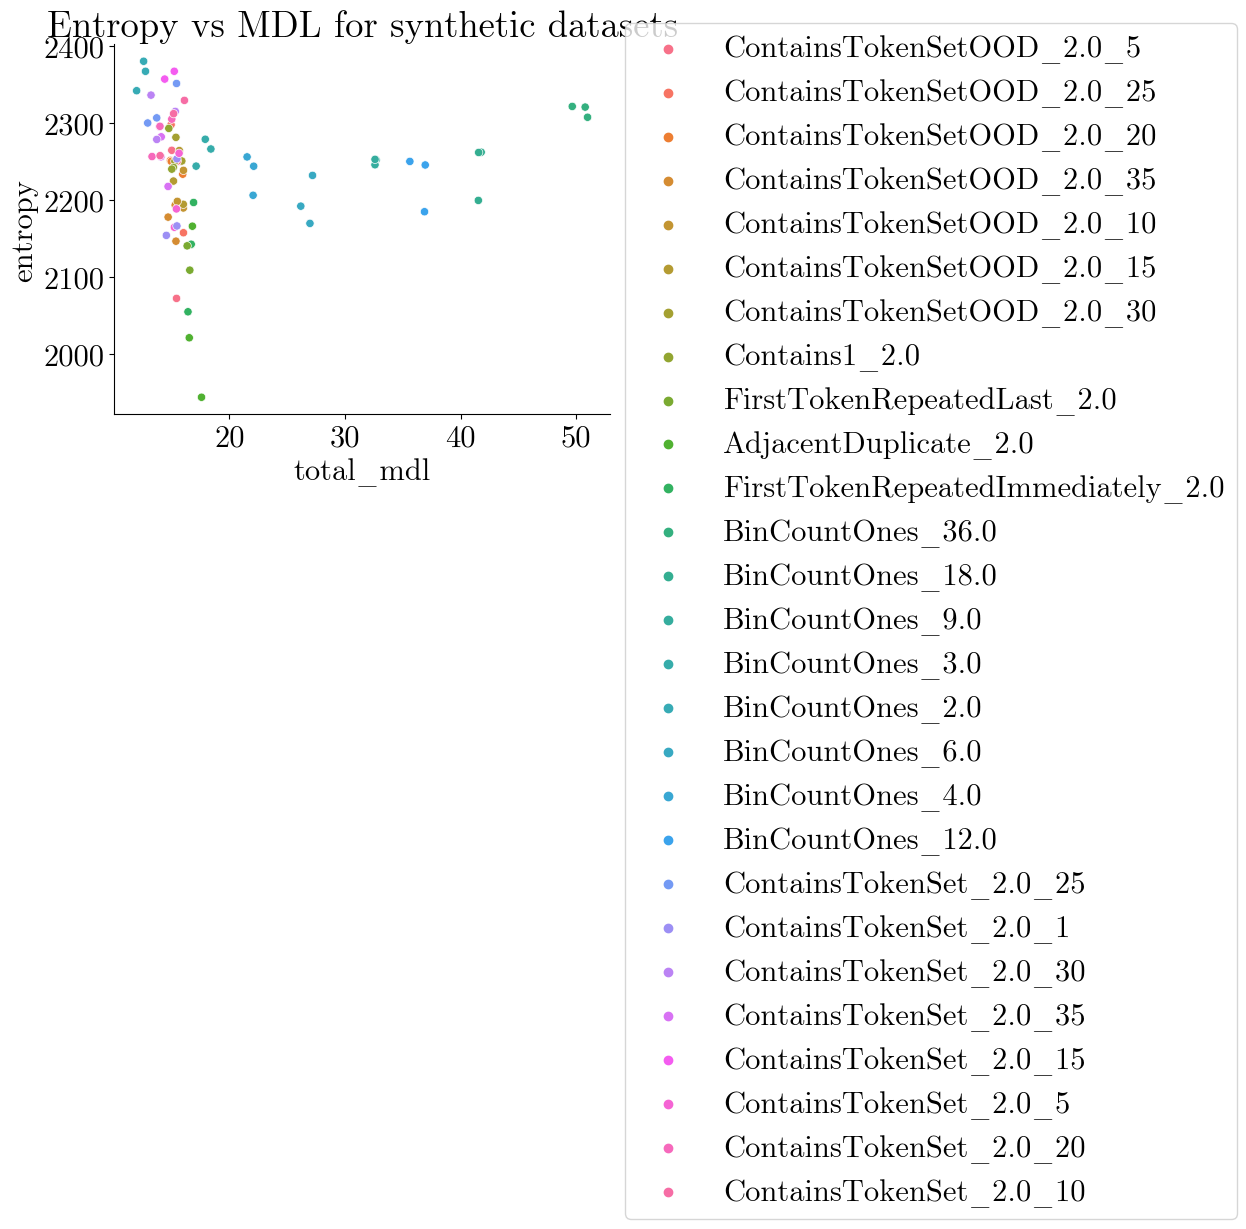

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df,
    x="total_mdl",
    y="entropy",
    hue="dataset",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 1.10))
ax.set_title("Entropy vs MDL for synthetic datasets")

Text(0.5, 1.0, 'Entropy vs MDL for ContainsTokenSet datasets')

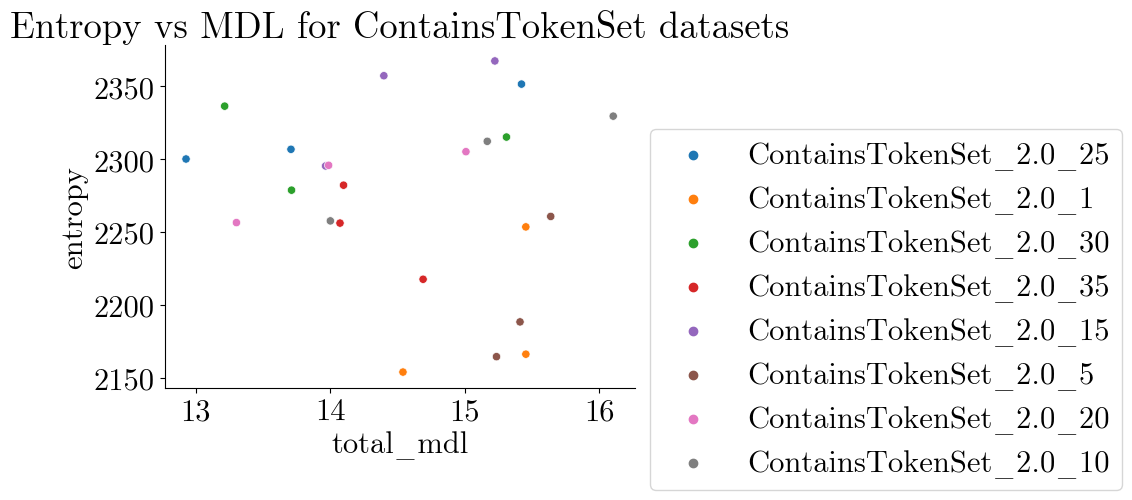

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df[mdl_and_entropy_df["DATASET_NAME"] == "ContainsTokenSet"],
    x="total_mdl",
    y="entropy",
    hue="dataset",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 0.8))
ax.set_title("Entropy vs MDL for ContainsTokenSet datasets")

Text(0.5, 1.0, 'Entropy vs MDL for BinCountOnes datasets')

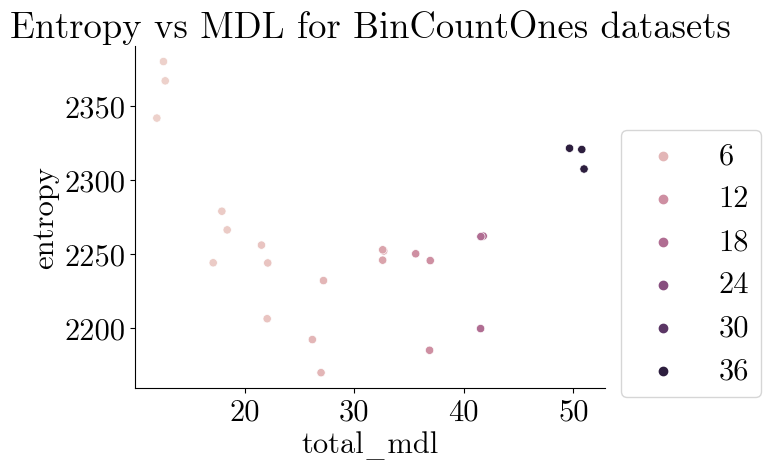

In [29]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df[mdl_and_entropy_df["DATASET_NAME"] == "BinCountOnes"],
    x="total_mdl",
    y="entropy",
    hue="num_classes",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 0.8))
ax.set_title("Entropy vs MDL for BinCountOnes datasets")

Text(0.5, 1.0, 'Entropy vs MDL for synthetic datasets, colored by well-learned vs poorly-learned')

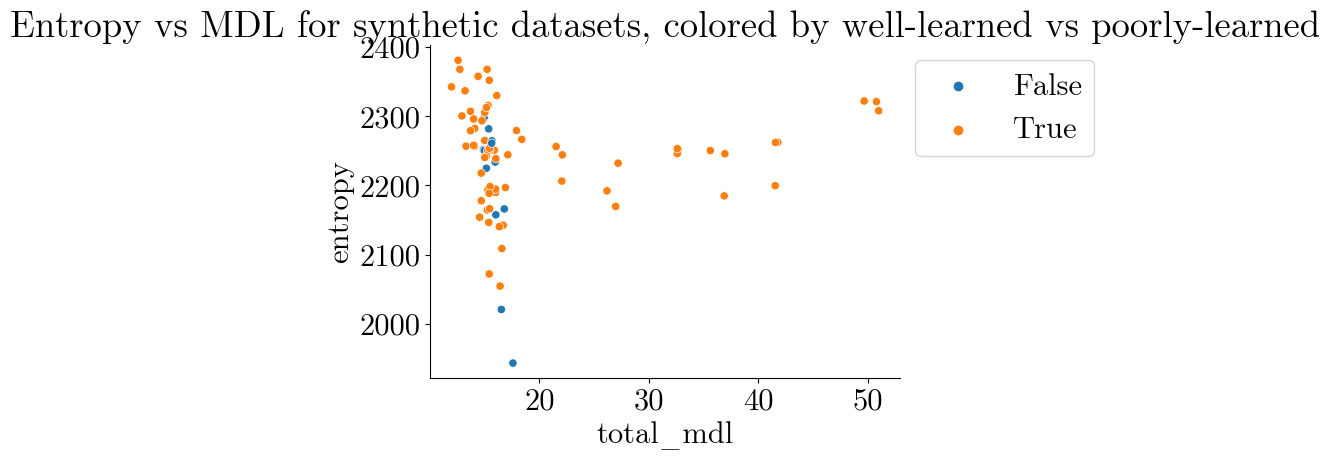

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df,
    x="total_mdl",
    y="entropy",
    hue="high_acc",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_title(
    "Entropy vs MDL for synthetic datasets, colored by well-learned vs poorly-learned"
)

Text(0.5, 1.0, 'Loss vs MDL for synthetic datasets, colored by well-learned vs poorly-learned')

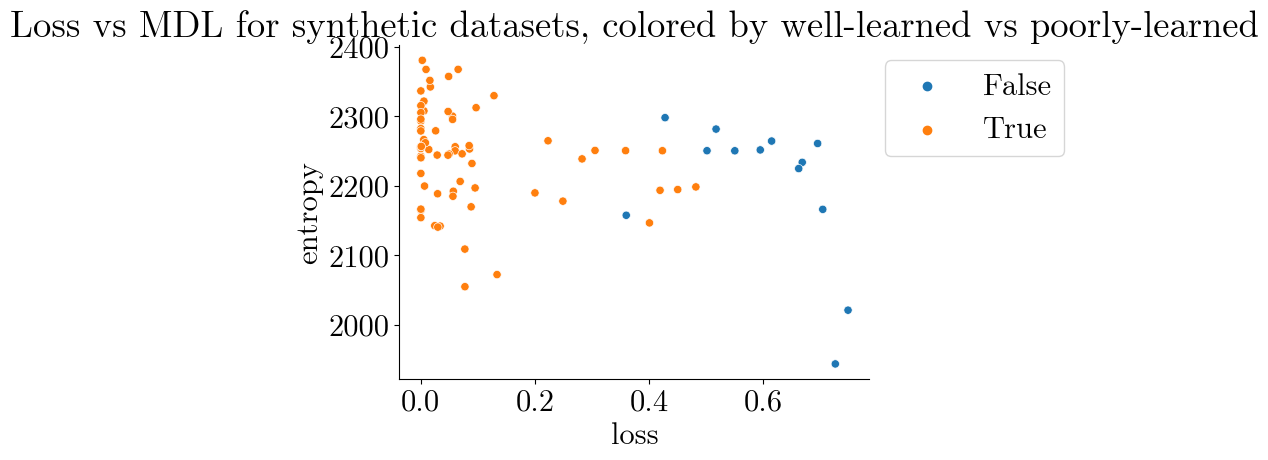

In [31]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df,
    x="loss",
    y="entropy",
    hue="high_acc",
    ax=ax,
)
fig.tight_layout()
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_title(
    "Loss vs MDL for synthetic datasets, colored by well-learned vs poorly-learned"
)

### Entropy of poorly learned vs well learned examples

In [32]:
import json

mdl_and_entropy_df["incorrect_example_inds"] = (
    mdl_and_entropy_df["is_correct_per_example"]
    .apply(json.loads)
    .apply(np.array)
    .apply(lambda x: np.where(x == 0)[0])
)
mdl_and_entropy_df["correct_example_inds"] = (
    mdl_and_entropy_df["is_correct_per_example"]
    .apply(json.loads)
    .apply(np.array)
    .apply(lambda x: np.where(x == 1)[0])
)
mdl_and_entropy_df["is_ood_example_inds"] = (
    mdl_and_entropy_df["val_X_is_ood"]
    .apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    .apply(np.array)
    .apply(lambda x: np.where(x == 1)[0])
)
mdl_and_entropy_df["is_not_ood_example_inds"] = (
    mdl_and_entropy_df["val_X_is_ood"]
    .apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    .apply(np.array)
    .apply(lambda x: np.where(x == 0)[0])
)
mdl_and_entropy_df["entropies_per_example_per_token"] = (
    mdl_and_entropy_df["entropies_per_example_per_token"]
    .apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    .apply(np.array)
)
mdl_and_entropy_df["val_data"] = (
    mdl_and_entropy_df["val_data"]
    .apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    .apply(np.array)
)
mdl_and_entropy_df["val_labels"] = (
    mdl_and_entropy_df["val_labels"]
    .apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    .apply(np.array)
)
np.array(mdl_and_entropy_df["entropies_per_example_per_token"].tolist()).shape

(81, 360, 36)

In [33]:
def get_mean_entropy_of_index_group(
    entropies_per_example_per_token: np.ndarray, indices: List[int]
) -> float:
    """
    entropies_per_example_per_token shape: (val_size, seq_len)
    indices shape: (val_size, X) where X in [1, ..., val_size - 1]
    """
    return entropies_per_example_per_token.take(indices, axis=0).mean()


def permutation_test(
    entropies_per_example_per_token: np.ndarray,
    ind_group1: np.ndarray,
    ind_group2: np.ndarray,
    group1_name: str = None,
    group2_name: str = None,
    num_permutations: int = 1000,
):
    """
    Goal: Is the difference between the entropy of ind_group1 significantly higher than entropy(indgroup2)?
    Permutation test method:
    0. permutation_results = np.zeros(shape=(num_permutations,))
    1. Compute true_diff = abs(mean(entropy(ind_group1)) - mean(entropy(ind_group2)))
    2. for i in range(num_permutations):
        fake_indgroup1, fake_indgroup2 = permute(ind_group1 + ind_group2) # len(fake_indgorup1) == len(indgorup1) and same for indgroup2
        fake_diff = abs(mean(entropy(fake_indgroup1)) - mean(entropy(fake_indgroup2)))
        permutation_results[i] = (true_diff <= fake_Diff) # for each random simulation, is the random difference bigger than the actual one?
    3. p_value = sum(permutation_results)/len(permutation_results) # when this is very low (e.g. < alpha=0.05), that means the entropy(ind_group1) probably is actually different than entropy(ind_group2)
    """

    def permute_in_groups(inds: set, size1: int, size2: int):
        assert len(inds) == size1 + size2
        g1 = np.random.choice(list(inds), size1, replace=False)
        g2 = np.array(list(inds.difference(set(g1))))
        return g1, g2

    permutation_results = np.zeros(shape=(num_permutations,))
    ind_group1_size = len(ind_group1)
    ind_group2_size = len(ind_group2)
    all_inds = set(ind_group1).union(set(ind_group2))
    true_diff = np.abs(
        get_mean_entropy_of_index_group(entropies_per_example_per_token, ind_group1)
        - get_mean_entropy_of_index_group(entropies_per_example_per_token, ind_group2)
    )
    for i in range(num_permutations):
        fake_indgroup1, fake_indgroup2 = permute_in_groups(
            all_inds, ind_group1_size, ind_group2_size
        )  # len(fake_indgorup1) == len(indgorup1) and same for indgroup2
        fake_diff = np.abs(
            get_mean_entropy_of_index_group(
                entropies_per_example_per_token, fake_indgroup1
            )
            - get_mean_entropy_of_index_group(
                entropies_per_example_per_token, fake_indgroup2
            )
        )
        permutation_results[i] = true_diff <= fake_diff

    return sum(permutation_results) / len(permutation_results)


def permutation_test_all_datasets(
    entropies_per_example_per_token_per_dataset: List[np.ndarray],
    ind_group1_per_dataset: List[np.ndarray],
    ind_group2_per_dataset: List[np.ndarray],
    group1_name: str = None,
    group2_name: str = None,
    num_permutations: int = 1000,
):
    assert (
        len(entropies_per_example_per_token_per_dataset)
        == len(ind_group1_per_dataset)
        == len(ind_group2_per_dataset)
    )
    permutation_probs = [
        permutation_test(
            entropies_per_example_per_token_per_dataset[i],
            ind_group1=ind_group1_per_dataset[i],
            ind_group2=ind_group2_per_dataset[i],
            group1_name=group1_name,
            group2_name=group2_name,
            num_permutations=num_permutations,
        )
        for i in range(len(entropies_per_example_per_token_per_dataset))
    ]
    return permutation_probs


def compare_example_entropies_between_two_groups(
    entropies_per_example_per_token_per_dataset: List[np.ndarray],
    ind_group1_per_dataset: List[np.ndarray],
    ind_group2_per_dataset: List[np.ndarray],
    group1_name: str = None,
    group2_name: str = None,
    num_permutations: int = 1000,
):
    """
    entropies_per_example_per_token - num_runs-sized list of np.ndarrays each with shape of (val_size, seq_len)
    ind_group1 - num_runs-sized list of np.ndarrays each with shape (val_size, X) where X may vary between [1, ..., val_size] which,
                    for each run i \in [0, len(num_runs) - 1], represents the rows of entropies_per_example_per_token[i] where the prediction was INCORRECT.
    ind_group2 - num_runs-sized list of np.ndarrays each with shape (val_size, X) where X may vary between [1, ..., val_size] which,
                    for each run i \in [0, len(num_runs) - 1], represents the rows of entropies_per_example_per_token[i] where the prediction was CORRECT.

    ind_group1[i] and ind_group2[i] should be mutually exclusive and jointly exhaustive from [0, ..., val_size - 1]
    """
    assert (
        len(entropies_per_example_per_token_per_dataset)
        == len(ind_group1_per_dataset)
        == len(ind_group2_per_dataset)
    )
    assert [
        (
            len(
                set(ind_group1_per_dataset[i]).intersection(
                    set(ind_group2_per_dataset[i])
                )
            )
            == 0
        )
        and (
            set(ind_group1_per_dataset[i]).union(set(ind_group2_per_dataset[i]))
            == set(range(entropies_per_example_per_token_per_dataset[i].shape[0]))
        )
        for i in range(len(entropies_per_example_per_token_per_dataset))
    ]  # ind_group1[i] and ind_group2[i] should be mutually exclusive and jointly exhaustive from [0, ..., val_size - 1]

    entropies_group1 = np.array(
        [
            get_mean_entropy_of_index_group(
                entropies_per_example_per_token_per_dataset[i],
                ind_group1_per_dataset[i],
            )
            for i in range(len(entropies_per_example_per_token_per_dataset))
        ]
    )

    entropies_group2 = np.array(
        [
            get_mean_entropy_of_index_group(
                entropies_per_example_per_token_per_dataset[i],
                ind_group2_per_dataset[i],
            )
            for i in range(len(entropies_per_example_per_token_per_dataset))
        ]
    )

    fig, ax = plt.subplots()
    df = pd.DataFrame(
        {
            "index": range(len(entropies_group1)),
            "g1" if group1_name is None else group1_name: entropies_group1,
            "g2" if group2_name is None else group2_name: entropies_group2,
        }
    ).melt(id_vars=["index"], var_name="group", value_name="entropy")
    sns.lineplot(data=df, x="index", y="entropy", hue="group", ax=ax)
    # sns.lineplot(entropies_group2, color="orange", ax=ax)

    return (
        sst.ttest_ind(entropies_group1, entropies_group2),
        (entropies_group1 - entropies_group2).mean(),
        permutation_test_all_datasets(
            entropies_per_example_per_token_per_dataset,
            ind_group1_per_dataset,
            ind_group2_per_dataset,
            group1_name,
            group2_name,
            num_permutations,
        ),
    )

T-test difference between incorrect and correct predictions for mdl_and_entropy_df_sans_perfect: Ttest_indResult(statistic=-2.944069235225224, pvalue=0.003926469287415621). Mean diff: -1.194253678772256.
Permutation test results:                               dataset  SEED  perm test result  num_incorrect
31              AdjacentDuplicate_2.0     0            0.1264            202
24              AdjacentDuplicate_2.0     1            0.8263            173
26              AdjacentDuplicate_2.0     2            0.7557            187
45                  BinCountOnes_12.0     0            0.0957              8
52                  BinCountOnes_12.0     1            0.0414              6
44                  BinCountOnes_12.0     2            0.5411              5
50                   BinCountOnes_2.0     0            0.0000              2
48                   BinCountOnes_2.0     1            0.0003              2
38                   BinCountOnes_2.0     2            0.0035              1


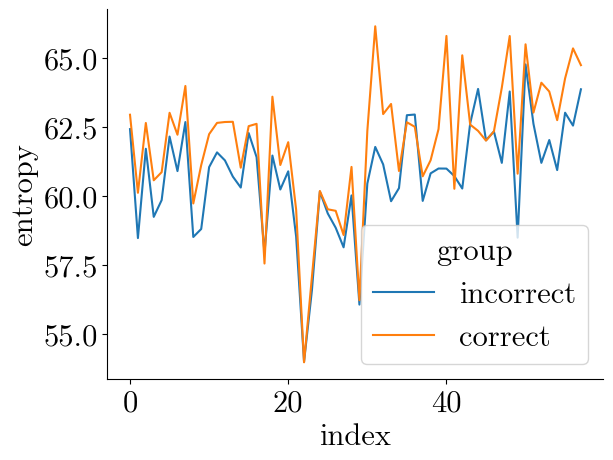

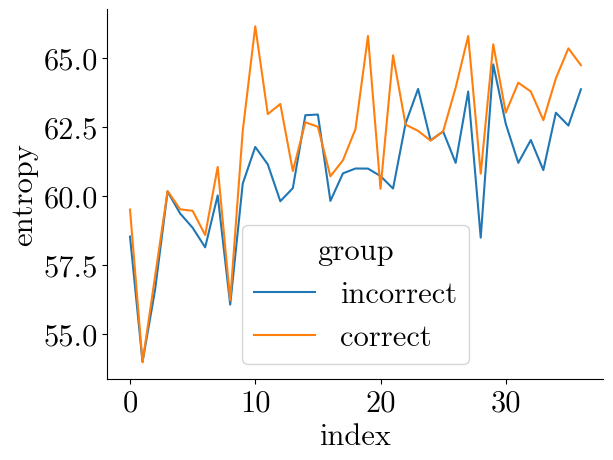

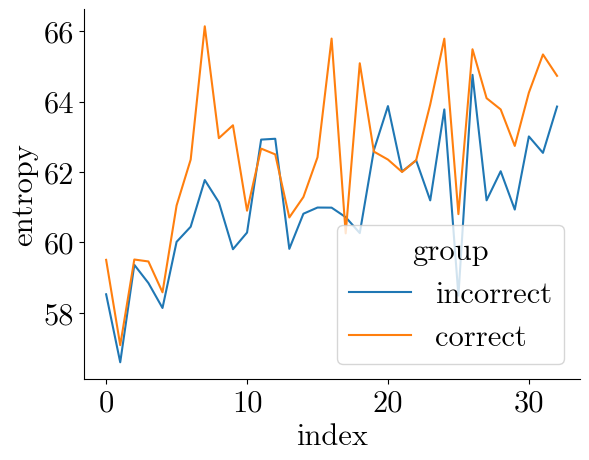

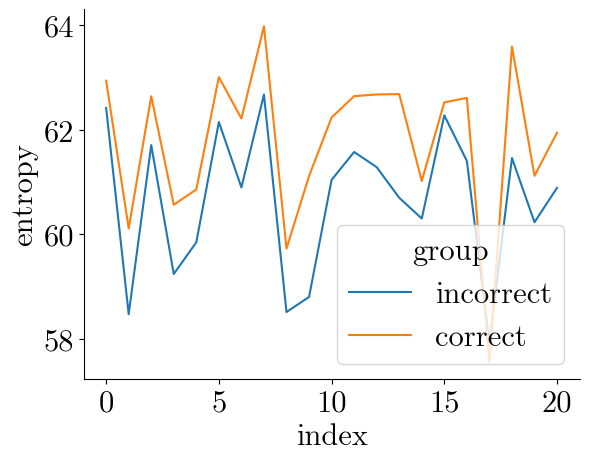

In [34]:
import scipy.stats as sst

mdl_and_entropy_df_sans_perfect = mdl_and_entropy_df[
    mdl_and_entropy_df["incorrect_example_inds"].apply(lambda x: len(x) > 0)
]
mdl_and_entropy_df_sans_perfect_no_ood = mdl_and_entropy_df_sans_perfect[
    mdl_and_entropy_df_sans_perfect["DATASET_NAME"] != "ContainsTokenSetOOD"
]
mdl_and_entropy_df_sans_perfect_no_ood_high_acc = (
    mdl_and_entropy_df_sans_perfect_no_ood[
        mdl_and_entropy_df_sans_perfect_no_ood["accuracy"] > 0.9
    ]
)
mdl_and_entropy_df_sans_perfect_ood_only = mdl_and_entropy_df_sans_perfect[
    mdl_and_entropy_df_sans_perfect["DATASET_NAME"] == "ContainsTokenSetOOD"
]

df_name_to_df = {
    "mdl_and_entropy_df_sans_perfect": mdl_and_entropy_df_sans_perfect,
    "mdl_and_entropy_df_sans_perfect_no_ood": mdl_and_entropy_df_sans_perfect_no_ood,
    "mdl_and_entropy_df_sans_perfect_no_ood_high_acc": mdl_and_entropy_df_sans_perfect_no_ood_high_acc,
    "mdl_and_entropy_df_sans_perfect_ood_only": mdl_and_entropy_df_sans_perfect_ood_only,
}
for df_name, df in df_name_to_df.items():
    (
        ttest_res,
        mean_diff,
        permutation_test_res,
    ) = compare_example_entropies_between_two_groups(
        df["entropies_per_example_per_token"].tolist(),
        df["incorrect_example_inds"].tolist(),
        df["correct_example_inds"].tolist(),
        group1_name="incorrect",
        group2_name="correct",
        num_permutations=10000,
    )
    print(
        f"T-test difference between incorrect and correct predictions for {df_name}: {ttest_res}. Mean diff: {mean_diff}."  # \nPermutation test results: {permutation_test_res}\n\n"
    )
    print(
        "Permutation test results:",
        pd.DataFrame(
            {
                "dataset": df["dataset"],
                "SEED": df["SEED"],
                "perm test result": permutation_test_res,
                "num_incorrect": df["incorrect_example_inds"].apply(len),
            }
        ).sort_values(["dataset", "SEED"]),
    )

### OOD examples

In [35]:
# Understand the held out test accuracy for different TOKENSETMAX's.
ood_mdl_df = mdl_df[mdl_df["DATASET_NAME"] == "ContainsTokenSetOOD"]
ood_mdl_df
expanded_df[expanded_df["DATASET_NAME"] == "ContainsTokenSetOOD"][
    ["tss-3600_test_acc", "TOKENSETMAX", "SEED"]
]

,tss-3600_test_acc,TOKENSETMAX,SEED
0,NaN,35,2
1,NaN,30,2
2,NaN,25,2
3,NaN,20,2
4,NaN,15,2
...,...,...,...
58,0.913889,15,0
59,0.872222,20,0
60,0.872222,15,2
61,0.897222,20,1


/tmp/ipykernel_202029/3891594483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdl_and_entropy_df_sans_perfect_ood_only.sort_values(


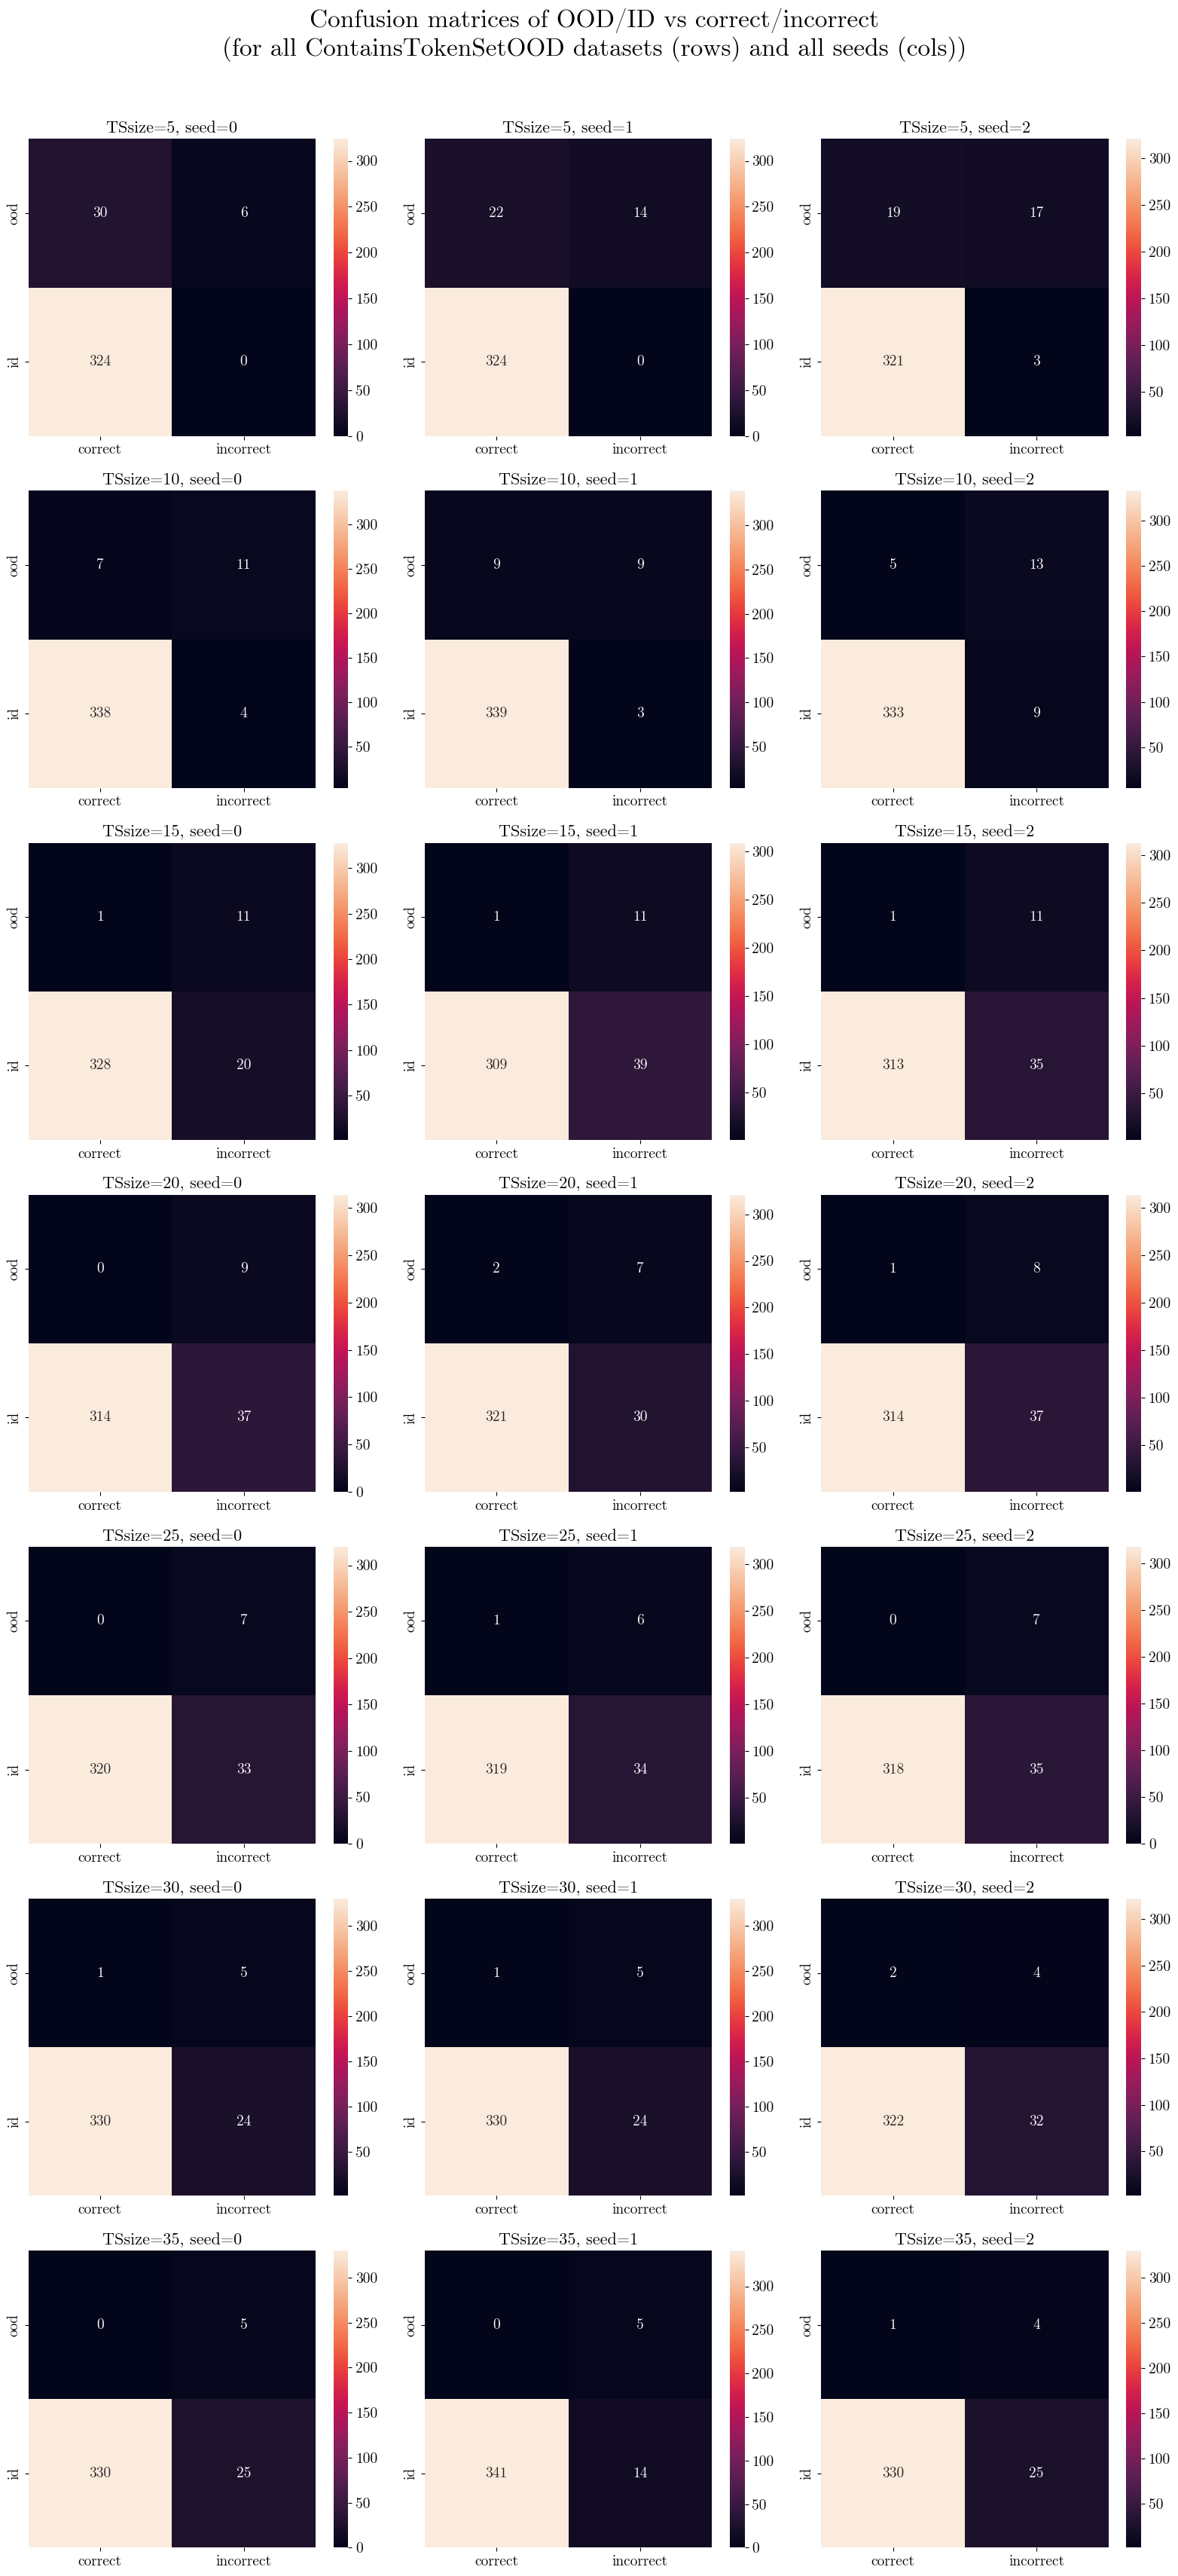

In [36]:
plt.rc("font", size=14)
mdl_and_entropy_df_sans_perfect_ood_only.sort_values(
    ["TOKENSETMAX", "SEED"], inplace=True
)
fig, axes = plt.subplots(
    ncols=3,
    nrows=np.ceil(len(mdl_and_entropy_df_sans_perfect_ood_only) // 3).astype(int),
    figsize=(16, 36),
)
for i in range(len(mdl_and_entropy_df_sans_perfect_ood_only)):
    row, col = i // 3, i % 3
    dataset = mdl_and_entropy_df_sans_perfect_ood_only.iloc[i]
    ood_inds = dataset["is_ood_example_inds"]
    id_inds = dataset["is_not_ood_example_inds"]
    correct_inds = dataset["correct_example_inds"]
    incorrect_inds = dataset["incorrect_example_inds"]
    num_ood_correct = len(set(ood_inds).intersection(set(correct_inds)))
    num_ood_incorrect = len(set(ood_inds).intersection(set(incorrect_inds)))
    num_id_correct = len(set(id_inds).intersection(set(correct_inds)))
    num_id_incorrect = len(set(id_inds).intersection(set(incorrect_inds)))

    # print(num_ood_correct, num_ood_incorrect, num_id_correct, num_id_incorrect)
    sns.heatmap(
        pd.DataFrame(
            [[num_ood_correct, num_ood_incorrect], [num_id_correct, num_id_incorrect]],
            columns=["correct", "incorrect"],
            index=["ood", "id"],
        ),
        annot=True,
        fmt="g",
        ax=axes[row][col],
    )
    axes[row][col].set_title(
        f"TSsize={dataset['TOKENSETMAX']}, seed={dataset['SEED']}", fontsize=16
    )

fig.suptitle(
    "Confusion matrices of OOD/ID vs correct/incorrect\n(for all ContainsTokenSetOOD datasets (rows) and all seeds (cols))",
    # wrap=True,
    fontsize=24,
)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

In [37]:
# Analyze overlap between OOD and incorrect examples
print("(not OOD and correct) / (not OOD or correct)")
print(
    mdl_and_entropy_df_sans_perfect_ood_only.apply(
        lambda x: len(
            set(x["is_not_ood_example_inds"]).intersection(
                set(x["correct_example_inds"])
            )
        )
        / len(set(x["is_not_ood_example_inds"]).union(set(x["correct_example_inds"]))),
        axis=1,
    )
)

print("\n(OOD and incorrect) / OOD")
print(
    mdl_and_entropy_df_sans_perfect_ood_only.apply(
        lambda x: len(
            set(x["is_ood_example_inds"]).intersection(set(x["incorrect_example_inds"]))
        )
        / len(
            set(x["is_ood_example_inds"])
        ),  # #.union(set(x["incorrect_example_inds"]))),
        axis=1,
    )
)

print("\n(OOD and correct) / OOD")
print(
    mdl_and_entropy_df_sans_perfect_ood_only.apply(
        lambda x: len(
            set(x["is_ood_example_inds"]).intersection(set(x["correct_example_inds"]))
        )
        / len(
            set(x["is_ood_example_inds"])
        ),  # #.union(set(x["incorrect_example_inds"]))),
        axis=1,
    )
)

(not OOD and correct) / (not OOD or correct)
17    0.915254
15    0.936416
0     0.935860
10    0.968481
4     0.965812
19    0.959654
14    0.939828
20    0.885387
5     0.896848
6     0.894587
2     0.909348
11    0.892045
1     0.906516
7     0.901130
12    0.900850
13    0.929577
16    0.929577
18    0.904494
8     0.929577
3     0.960563
9     0.926966
dtype: float64

(OOD and incorrect) / OOD
17    0.166667
15    0.388889
0     0.472222
10    0.611111
4     0.500000
19    0.722222
14    0.916667
20    0.916667
5     0.916667
6     1.000000
2     0.777778
11    0.888889
1     1.000000
7     0.857143
12    1.000000
13    0.833333
16    0.833333
18    0.666667
8     1.000000
3     1.000000
9     0.800000
dtype: float64

(OOD and correct) / OOD
17    0.833333
15    0.611111
0     0.527778
10    0.388889
4     0.500000
19    0.277778
14    0.083333
20    0.083333
5     0.083333
6     0.000000
2     0.222222
11    0.111111
1     0.000000
7     0.142857
12    0.000000
13    0.166667
16 

('10', '15', '20', '25', '30', '35', '5')


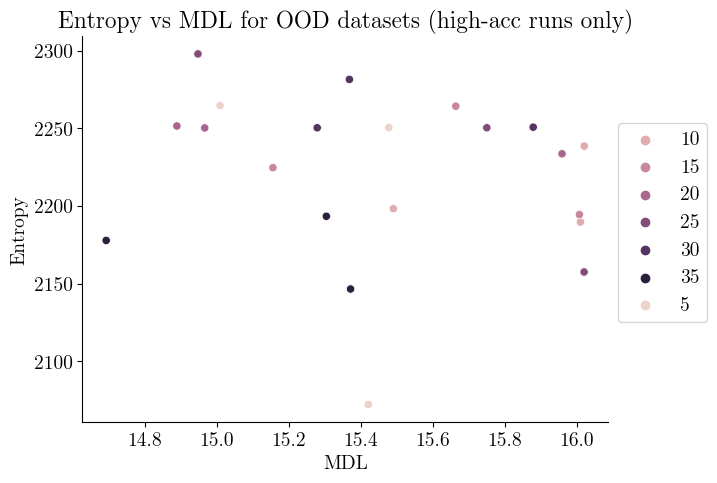

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mdl_and_entropy_df_sans_perfect_ood_only,
    x="total_mdl",
    y="entropy",
    hue="TOKENSETMAX",
    ax=ax,
)
fig.tight_layout()
ax.set_title("Entropy vs MDL for OOD datasets (high-acc runs only)")
ax.set_xlabel("MDL")
ax.set_ylabel("Entropy")

# Create a new legend with the desired order using a lambda function
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = zip(
    *sorted(
        zip(handles, labels),
        key=lambda x: (
            x[1].split("_")[0],  # This sorts the datasets by their name
            float(x[1].split("_")[-1]),  # This sorts by the ContainsTokenSet size
        ),
    )
)
print(new_labels)
ax.legend(new_handles, new_labels, bbox_to_anchor=(1.0, 0.8))

save_path = os.path.join(PLOTS_DIR, "entropy_vs_mdl_ood.png")
save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_mdl_ood.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"entropy_vs_mdl_ood": wandb.Image(save_path)})

T-test difference between incorrect and correct predictions for mdl_and_entropy_df_sans_perfect_ood_only: Ttest_indResult(statistic=-1.6017440215628502, pvalue=0.11708123463048696). Mean diff: -0.7183004744221919.
Permutation test results:                        dataset  SEED  perm test result  num_incorrect
10  ContainsTokenSetOOD_2.0_10     0             0.008             15
4   ContainsTokenSetOOD_2.0_10     1             0.000             12
19  ContainsTokenSetOOD_2.0_10     2             0.002             22
14  ContainsTokenSetOOD_2.0_15     0             0.047             31
20  ContainsTokenSetOOD_2.0_15     1             0.000             50
5   ContainsTokenSetOOD_2.0_15     2             0.269             46
6   ContainsTokenSetOOD_2.0_20     0             0.111             46
2   ContainsTokenSetOOD_2.0_20     1             0.002             37
11  ContainsTokenSetOOD_2.0_20     2             0.349             45
1   ContainsTokenSetOOD_2.0_25     0             0.226      

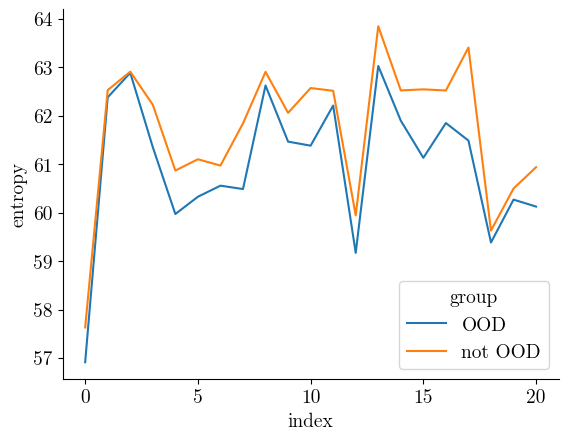

In [39]:
df_name_to_df = {
    "mdl_and_entropy_df_sans_perfect_ood_only": mdl_and_entropy_df_sans_perfect_ood_only,
}
for df_name, df in df_name_to_df.items():
    (
        ttest_res,
        mean_diff,
        permutation_test_res,
    ) = compare_example_entropies_between_two_groups(
        df["entropies_per_example_per_token"].tolist(),
        df["is_ood_example_inds"].tolist(),
        df["is_not_ood_example_inds"].tolist(),
        group1_name="OOD",
        group2_name="not OOD",
    )
    print(
        f"T-test difference between incorrect and correct predictions for {df_name}: {ttest_res}. Mean diff: {mean_diff}."  # \nPermutation test results: {permutation_test_res}\n\n"
    )
    print(
        "Permutation test results:",
        pd.DataFrame(
            {
                "dataset": df["dataset"],
                "SEED": df["SEED"],
                "perm test result": permutation_test_res,
                "num_incorrect": df["incorrect_example_inds"].apply(len),
            }
        ).sort_values(["dataset", "SEED"]),
    )

In [40]:
# Test that the is_ood do indeed satisfy the OOD condition.
mdl_and_entropy_df_sans_perfect_ood_only[
    ["TOKENSETMAX", "val_data", "is_ood_example_inds"]
]
[
    (
        len(
            set(
                np.take(
                    mdl_and_entropy_df_sans_perfect_ood_only["val_data"].iloc[d],
                    mdl_and_entropy_df_sans_perfect_ood_only[
                        "is_ood_example_inds"
                    ].iloc[d],
                    axis=0,
                )[i]
            ).intersection(
                set(
                    range(
                        1,
                        mdl_and_entropy_df_sans_perfect_ood_only.iloc[d]["TOKENSETMAX"]
                        + 1,
                    )
                )
            )
        ),
        mdl_and_entropy_df_sans_perfect_ood_only.iloc[d]["TOKENSETMAX"],
    )
    for d in range(len(mdl_and_entropy_df_sans_perfect_ood_only))
    for i in range(
        len(mdl_and_entropy_df_sans_perfect_ood_only["is_ood_example_inds"].iloc[d])
    )
][:5]

[(4, 5), (4, 5), (4, 5), (4, 5), (4, 5)]

In [41]:
mdl_and_entropy_df_sans_perfect_ood_only["is_ood_example_inds"].apply(len)

17    36
15    36
0     36
10    18
4     18
19    18
14    12
20    12
5     12
6      9
2      9
11     9
1      7
7      7
12     7
13     6
16     6
18     6
8      5
3      5
9      5
Name: is_ood_example_inds, dtype: int64

In [42]:
wandb.finish()